# Отчет. Группа 3

In [ ]:
!pip install cvxpy numdifftools

In [ ]:
import cvxpy as cp
import numpy as np
import numdifftools as nd
import tqdm
import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_spd_matrix

## Пункт 1
Запишем нашу задачу минимизации:
$$
min (1 + x_1^2)^{1/2} + ∑_{i=1}^{n-1}(1 + (x_{i+1}-x_i)^2)^{1/2} \\
Ax = b \\
x_i >= 0,  \forall_i=̅\overline{1, n}
$$

Введем логарифмический барьер
$$
\phi(x)= -\frac{1}{t}\sum\limits_{i=1}^m\ln(-f_i(x)) =  -\frac{1}{t}\sum\limits_{i=1}^m\ln(x_i)
$$
где $f_i(x), \ i \in \{1, \ m\}$, - ограничения-неравенства исходной задачи$

Согласно методу логарифмических барьеров, задачу можно свести к следующей:

$$
min (1 + x_1^2)^{1/2} + ∑_{i=1}^{n-1}(1 + (x_{i+1}-x_i)^2)^{1/2}  - \frac{1}{t}\sum\limits_{i=1}^m\ln(x_i) \\
Ax = b \\
$$


Далее эту задачу будем решать методом Ньютона с ограничениями-равенствами, поэтому должны нужно вычислить градиент и матрицу вторых производных:

$$
\nabla f_0(x) =
\begin{pmatrix}
\frac{x_1}{\sqrt{x_1^2+1}}-\frac{x_2-x_1}{\sqrt{(x_2-x_1)^2+1}} - \frac{1}{tx_1}\\
\vdots\\
\frac{x_i-x_{i-1}}{\sqrt{\left( x_i-x_{i-1}\right)^2+1}}-\frac{x_{i+1}-x_i}{\sqrt{\left( x_{i+1}-x_{i})^2+1\right)}} - \frac{1}{tx_i} \\
\vdots\\
\frac{x_n-x_{n-1}}{\sqrt{\left(x_n-x_{n-1} \right)^2+1}} - \frac{1}{tx_n}
\end{pmatrix}, \ где \ \forall_i=\overline{2, n-1}
$$


$$
\frac{d}{dx_1} \left( \frac{x_2-x_1}{{\left( \left( x_2-x_1\right)^2+1\right)^{1/2}}}\right)=-\frac{d}{dx_2}  \left( \frac{x_2-x_1}{{\left( \left( x_2-x_1\right)^2+1\right)^{1/2}}}\right)=- \frac{1}{{\left( \left( x_2-x_1\right)^2+1\right)^{3/2}}}
$$

Пусть
$$
z(x_1,x_2)= \frac{1}{\left(\left(x_2-x_1\right)^2+1\right)^{3/2}}
$$

Тогда:
$$
H(x)=
\begin{pmatrix}
\frac{1}{\left(x_1^2+1\right)^{3/2}}+z(x_1,x_2) + \frac{1}{t x_1^2} & -z(x_1,x_2) &  0 & 0 & ... & 0\\
-z(x_1,x_2) & z(x_1,x_2)+z(x_2,x_3) + \frac{1}{t x_2^2} & -z(x_2,x_3) & 0 & ... & 0\\
\underbrace{0 \ \ \ \ \ \ \ ...\ \ \ \  0}_\text{i-2} &  -z(x_{i-1},x_i) & z(x_i, x_{i+1})+z(x_{i-1},x_i) + \frac{1}{t x_i^2} & -z(x_{i+1}, x_i) & \underbrace{0 \ \ \ \ \ \ \ ...\ \ \ \  0}_\text{n-i-1}\\
\vdots\\
0 & ... & ... & 0  & -z(x_{n-1},x_n) & z(x_{n-1},x_n) + \frac{1}{t x_n^2}
\end{pmatrix}, , \  \ \forall_i=\overline{2, n-1}
$$

На паре вывели условия минимума:

\begin{equation*}
 \begin{cases}
   H(x^{(k)}) \cdot x + A^T\mu = - \nabla f_0(x^{(k)}) + H(x^{(k)})\cdot x^{(k)},
   \\
   Ax + 0 \cdot \mu = b
 \end{cases}
\end{equation*}



Это можно записать в следующем виде:

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} x\\\\ \mu
    \end{pmatrix} =\begin{pmatrix} H(x^{(k)}) \cdot x^{(k)} - \nabla f_0(x^{(k)}) \\\\b\end{pmatrix}
$$

## Пункт 2
Для каждого n из {10, 20, ..., 100} сгенерируйте N=100 примеров. С помощью CVX найдите глобальный минимум $x^* \in R^n$

In [ ]:
gena = np.random.default_rng(42)

n_range = np.arange(10, 51, 10)
m_range = (n_range * .5).astype(int)
N = 10
data = {}

pbar = tqdm.tqdm(total=n_range.shape[0]*N, position=0, leave=True)
for n, m in zip(n_range, m_range):
  data[n] = {}
  i = 0
  while i < N:
    A = gena.normal(size=(m, n))
    b = gena.normal(size=(m))

    x = cp.Variable(n)
    obj = cp.Minimize(cp.norm(cp.vstack((1, x[0])), 2) +
                      cp.sum([cp.norm(cp.vstack((1, x[j + 1] - x[j])), 2) for j in range(0, n-1)]))
    constraints = [A @ x == b, x >= 0]
    prob = cp.Problem(obj, constraints)
    try:
      prob.solve(verbose = False)
    except cp.SolverError:
      prob.solve(solver=cp.SCS, verbose = False)
    if x.value is None:
      # print(f"No solution for x: {x}")
      continue
    print("Optimal value: ", prob.value)
    # print("Optimal solution: ", x.value)
    data[n][i] = {}
    data[n][i]['A'] = A
    data[n][i]['b'] = b
    data[n][i]['x_true'] = x.value
    data[n][i]['y_true'] = prob.value
    i += 1
    pbar.update(1)

  2%|▏         | 2/100 [00:00<00:21,  4.53it/s]

Optimal value:  10.55708297069898
Optimal value:  11.120455553488453


  4%|▍         | 4/100 [00:00<00:18,  5.23it/s]

Optimal value:  13.68238047236537
Optimal value:  12.080241575972199


  6%|▌         | 6/100 [00:01<00:16,  5.78it/s]

Optimal value:  18.085758131369932
Optimal value:  12.523106713114014


  7%|▋         | 7/100 [00:01<00:19,  4.70it/s]

Optimal value:  12.334330008513268


  8%|▊         | 8/100 [00:01<00:20,  4.38it/s]

Optimal value:  11.804911648535334


  9%|▉         | 9/100 [00:01<00:20,  4.39it/s]

Optimal value:  10.748007563161385


 10%|█         | 10/100 [00:02<00:27,  3.23it/s]

Optimal value:  10.67133857035734


 11%|█         | 11/100 [00:03<00:40,  2.20it/s]

Optimal value:  22.107268406057894


 12%|█▏        | 12/100 [00:03<00:40,  2.16it/s]

Optimal value:  24.89656114158922


 13%|█▎        | 13/100 [00:04<00:57,  1.50it/s]

Optimal value:  24.296731429068316


 14%|█▍        | 14/100 [00:05<00:56,  1.52it/s]

Optimal value:  21.414941042105106


 15%|█▌        | 15/100 [00:07<01:27,  1.02s/it]

Optimal value:  21.83852816932175


 16%|█▌        | 16/100 [00:07<01:14,  1.13it/s]

Optimal value:  21.532336955528017


 17%|█▋        | 17/100 [00:08<01:04,  1.29it/s]

Optimal value:  21.360897048126468


 18%|█▊        | 18/100 [00:09<01:21,  1.00it/s]

Optimal value:  20.429123079953758


 19%|█▉        | 19/100 [00:10<01:03,  1.27it/s]

Optimal value:  20.95537177618758


 20%|██        | 20/100 [00:10<00:52,  1.53it/s]

Optimal value:  20.413112266473476


 21%|██        | 21/100 [00:11<01:03,  1.24it/s]

Optimal value:  36.61195885748986


 22%|██▏       | 22/100 [00:12<00:54,  1.42it/s]

Optimal value:  34.26674656073049


 23%|██▎       | 23/100 [00:13<00:58,  1.31it/s]

Optimal value:  35.4589769983922


 24%|██▍       | 24/100 [00:13<00:47,  1.59it/s]

Optimal value:  33.15342850099759


 25%|██▌       | 25/100 [00:13<00:42,  1.77it/s]

Optimal value:  31.11900517123136


 26%|██▌       | 26/100 [00:14<00:39,  1.85it/s]

Optimal value:  31.041957359891587


 27%|██▋       | 27/100 [00:15<00:51,  1.40it/s]

Optimal value:  35.38454165902702
Optimal value:  31.002386936957844


 29%|██▉       | 29/100 [00:16<00:40,  1.74it/s]

Optimal value:  50.92620203502769


 30%|███       | 30/100 [00:19<01:34,  1.35s/it]

Optimal value:  35.28461234677376


 32%|███▏      | 32/100 [00:19<00:51,  1.31it/s]

Optimal value:  45.928763619213264
Optimal value:  44.945800465506515


 33%|███▎      | 33/100 [00:21<01:06,  1.00it/s]

Optimal value:  41.669313880057054


 34%|███▍      | 34/100 [00:21<00:57,  1.14it/s]

Optimal value:  40.87893978544463


 35%|███▌      | 35/100 [00:22<00:51,  1.27it/s]

Optimal value:  41.645713427898485


 36%|███▌      | 36/100 [00:24<01:04,  1.01s/it]

Optimal value:  42.46872913900071


 38%|███▊      | 38/100 [00:24<00:39,  1.57it/s]

Optimal value:  42.25640533720384
Optimal value:  46.83246663986778


 40%|████      | 40/100 [00:24<00:23,  2.57it/s]

Optimal value:  41.33775284687987
Optimal value:  96.04884643121585


 41%|████      | 41/100 [00:25<00:22,  2.62it/s]

Optimal value:  55.03964389267847


 42%|████▏     | 42/100 [00:25<00:21,  2.68it/s]

Optimal value:  53.247985752735


 43%|████▎     | 43/100 [00:25<00:20,  2.73it/s]

Optimal value:  55.674151177145966


 44%|████▍     | 44/100 [00:26<00:18,  3.00it/s]

Optimal value:  57.36857950057297


 46%|████▌     | 46/100 [00:26<00:14,  3.61it/s]

Optimal value:  52.52620721313811
Optimal value:  56.04141905937934


 47%|████▋     | 47/100 [00:26<00:15,  3.41it/s]

Optimal value:  98.14827112428028


 48%|████▊     | 48/100 [00:27<00:14,  3.64it/s]

Optimal value:  57.48396624459225


 49%|████▉     | 49/100 [00:27<00:17,  3.00it/s]

Optimal value:  54.52162381988299


 50%|█████     | 50/100 [00:27<00:15,  3.29it/s]

Optimal value:  52.393519707631704


 51%|█████     | 51/100 [00:28<00:14,  3.44it/s]

Optimal value:  61.92839684889828


 52%|█████▏    | 52/100 [00:28<00:14,  3.39it/s]

Optimal value:  141.49422865291095


 54%|█████▍    | 54/100 [00:29<00:12,  3.54it/s]

Optimal value:  64.74136989158575
Optimal value:  63.87668795204971


 55%|█████▌    | 55/100 [00:29<00:12,  3.65it/s]

Optimal value:  70.78612731072904


 57%|█████▋    | 57/100 [00:29<00:11,  3.72it/s]

Optimal value:  75.35898605098683
Optimal value:  69.0383352813409


 59%|█████▉    | 59/100 [00:30<00:08,  4.77it/s]

Optimal value:  72.10476984169523
Optimal value:  61.663679256992495


 61%|██████    | 61/100 [00:30<00:09,  4.28it/s]

Optimal value:  70.24808537428396
Optimal value:  510.5406613624803


 63%|██████▎   | 63/100 [00:31<00:13,  2.81it/s]

Optimal value:  72.60714844494017
Optimal value:  80.74926738832555


 64%|██████▍   | 64/100 [00:32<00:10,  3.35it/s]

Optimal value:  101.5786512521609


 65%|██████▌   | 65/100 [00:32<00:13,  2.57it/s]

Optimal value:  87.85788283411532


 67%|██████▋   | 67/100 [00:33<00:10,  3.14it/s]

Optimal value:  76.3026654351204
Optimal value:  109.13128608923961


 68%|██████▊   | 68/100 [00:33<00:09,  3.54it/s]

Optimal value:  73.54684393526415


 70%|███████   | 70/100 [00:34<00:09,  3.32it/s]

Optimal value:  71.44635878358622
Optimal value:  74.72692080031325


 71%|███████   | 71/100 [00:34<00:10,  2.67it/s]

Optimal value:  88.43459855467643


 72%|███████▏  | 72/100 [00:35<00:13,  2.06it/s]

Optimal value:  90.83818373448435


 73%|███████▎  | 73/100 [00:36<00:18,  1.45it/s]

Optimal value:  82.37112186648096


 74%|███████▍  | 74/100 [00:37<00:18,  1.43it/s]

Optimal value:  82.5919204534841


 75%|███████▌  | 75/100 [00:37<00:16,  1.49it/s]

Optimal value:  88.72015011581352


 77%|███████▋  | 77/100 [00:38<00:10,  2.21it/s]

Optimal value:  125.01105553408699
Optimal value:  113.21322627181651


 79%|███████▉  | 79/100 [00:38<00:07,  2.92it/s]

Optimal value:  82.6211235103016
Optimal value:  90.96041512591806


 80%|████████  | 80/100 [00:39<00:06,  3.33it/s]

Optimal value:  127.85119816867797


 81%|████████  | 81/100 [00:39<00:06,  2.99it/s]

Optimal value:  92.75071028097759


 82%|████████▏ | 82/100 [00:40<00:08,  2.14it/s]

Optimal value:  100.01245860345013


 83%|████████▎ | 83/100 [00:40<00:06,  2.57it/s]

Optimal value:  92.51923311900309


 84%|████████▍ | 84/100 [00:41<00:07,  2.03it/s]

Optimal value:  142.45358985937258


 85%|████████▌ | 85/100 [00:41<00:06,  2.44it/s]

Optimal value:  93.06544239618125


 86%|████████▌ | 86/100 [00:41<00:06,  2.25it/s]

Optimal value:  170.42824916768797


 87%|████████▋ | 87/100 [00:42<00:06,  2.02it/s]

Optimal value:  234.74418398164823


 88%|████████▊ | 88/100 [00:43<00:06,  1.99it/s]

Optimal value:  96.34548152071538


 89%|████████▉ | 89/100 [00:43<00:05,  1.86it/s]

Optimal value:  102.14274643877646


 90%|█████████ | 90/100 [00:43<00:04,  2.09it/s]

Optimal value:  91.43961411000711


 91%|█████████ | 91/100 [00:44<00:03,  2.44it/s]

Optimal value:  108.74356307180574


 92%|█████████▏| 92/100 [00:44<00:02,  2.76it/s]

Optimal value:  118.65838372516028


 93%|█████████▎| 93/100 [00:44<00:02,  3.11it/s]

Optimal value:  105.74399568008913


 94%|█████████▍| 94/100 [00:45<00:02,  2.99it/s]

Optimal value:  102.11743091415424


 95%|█████████▌| 95/100 [00:45<00:01,  2.57it/s]

Optimal value:  102.69392025864607


 96%|█████████▌| 96/100 [00:45<00:01,  2.84it/s]

Optimal value:  105.48645570595109


 97%|█████████▋| 97/100 [00:46<00:01,  2.25it/s]

Optimal value:  103.80146615320743


 98%|█████████▊| 98/100 [00:46<00:00,  2.23it/s]

Optimal value:  103.08636344482525


 99%|█████████▉| 99/100 [00:47<00:00,  2.35it/s]

Optimal value:  104.8087006292636


100%|██████████| 100/100 [00:48<00:00,  1.95it/s]

Optimal value:  103.38950506036326


# Пункт 3
Для каждого значения n = [10,100] и для каждого тестового примера сгенерируйте 100 начальных точек. Для заданной точности по значению фунции 𝜺 = 0.01 решите задачу с помощью метода лог барьеров для различных значений параметра μ ∈ {2, 10, 50, 100} и t0 = 1. Приведите необходимые аналитические вычисления.

## Naive Newton

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} x\\\\ \mu
    \end{pmatrix} =\begin{pmatrix} H(x^{(k)}) \cdot x^{(k)} - \nabla f_0(x^{(k)}) \\\\b\end{pmatrix}
$$

In [ ]:
def make_z(x):
  def z(i):
    return 1 / np.power((x[i + 1] - x[i]) ** 2 + 1, 3/2)
  return z

def make_u(x):
  def u(i):
    return (x[i + 1] - x[i]) / np.sqrt((x[i + 1] - x[i]) ** 2 + 1)
  return u

# Гессе
def make_h(x, t):
  n = x.shape[0]
  h = np.zeros((n, n))
  z = make_z(x)

  h[0][0] = 1 / np.power(x[0] ** 2 + 1, 3/2) + z(0) + 1 / (t * (x[0] ** 2))
  h[0][1] = -z(0)
  for i in range(1, n - 1):
    h[i][i - 1] = -z(i - 1)
    h[i][i] = z(i - 1) + z(i) + 1 / (t * (x[i] ** 2))
    h[i][i + 1] = -z(i)
  h[n-1][n-1] = z(n-2) + 1 / (t * (x[n-1] ** 2))
  h[n-1][n-2] = -z(n-2)
  return h

# Градиент
def make_grad(x, t):
  n = x.shape[0]
  grad = np.zeros((n))
  u = make_u(x)

  grad[0] = x[0] / np.sqrt(x[0] ** 2 + 1) - u(0) - 1 / (t * x[0])
  for i in range(1, n - 1):
    grad[i] = u(i - 1) - u(i) - 1 / (t * x[i])
  grad[n - 1] = u(n - 2) - 1 / (t * x[n - 1])
  return grad

# Подсчет функции
def calc_f(x):
    return np.sqrt(1 + x[0]**2) + np.sum([np.sqrt(1 + (x[i+1]-x[i])**2) for i in range(x.shape[0] - 1)])

def make_projection(x, A, b):
  return x - A.T @ np.linalg.inv(A @ A.T) @ (A @ x - b)

In [ ]:
def iter_newton(x, A, b, t):
  left_mtx = np.block([[make_h(x, t), A.T],[A, np.zeros(shape=(A.shape[0], A.shape[0]))]])
  right_mtx = np.concatenate((make_h(x, t) @ x - make_grad(x, t), b))
  return np.linalg.solve(left_mtx, right_mtx)[:x.shape[0]]

In [ ]:
n_starts = 5  # 100
eps = 0.01
max_iters = 30
t_multiplier_range = [2, 4, 6, 8, 10]
statistic_naive = {t_multiplier: {"time": [], "iters": [], "no_sol_cnt": []} for t_multiplier in t_multiplier_range}

pbar = tqdm.tqdm(total=n_range.shape[0] * N * n_starts * len(t_multiplier_range), position=0, leave=True)
for t_multiplier in t_multiplier_range:
    mu_str = str(t_multiplier)
    for n, m in zip(n_range, m_range):
        no_sol_cnt = 0
        current_iters = 0
        time_start = time.time()
        for i in range(N):
            for start in range(n_starts):
                A = data[n][i]["A"]
                b = data[n][i]["b"]
                y_true = data[n][i]["y_true"]
                x = gena.normal(size=(n))
                x = make_projection(x, A, b)
                data[n][i][f"x_{start}"] = x.copy()
                t = 1
                while (n / t >= eps):
                    iter_cnt = 0
                    while not np.isclose(calc_f(x), y_true, atol=eps):
                        iter_cnt += 1
                        x = iter_newton(x, A, b, t)
                        for xi in range(len(x)):
                            if x[xi] < 0:
                                x[xi] = 1e-2
                        if iter_cnt == max_iters:
                            break
                    current_iters += iter_cnt
                    t *= t_multiplier
                    if (np.isclose(calc_f(x), y_true, atol=eps)):
                        break
                if (not np.isclose(calc_f(x), y_true, atol=eps)):
                    # print("no")
                    no_sol_cnt += 1
                else:
                    pass
                    # print("YES")

                pbar.update(1)
        statistic_naive[t_multiplier]["iters"].append(current_iters / N / n_starts)
        statistic_naive[t_multiplier]["time"].append((time.time() - time_start) / N / n_starts)
        statistic_naive[t_multiplier]["no_sol_cnt"].append(no_sol_cnt)

100%|██████████| 2500/2500 [39:03<00:00,  1.59s/it]

### Здесь решение не стало расходиться благодаря проекции x >= 0, поэтому можно взглянуть на результаты. Однако, поскольку у нас уже написан и другой метод Ньютона, сравним их по критерию сходимости

## Newton step at infeasible points. Interpretation as primal-dual Newton step

$$
    \begin{pmatrix}
    H(x^{(k)}) & A^T\\\\
    A & 0\\\\
    \end{pmatrix} \times \begin{pmatrix} \Delta x\\\\\Delta \mu
    \end{pmatrix} = - \begin{pmatrix} \nabla f_0(x^{(k)}) + A^T\mu^{(k)} \\\\Ax^{(k)} - b\end{pmatrix}
$$

Шаг (t) уменьшается в соответствие со следующими правилами:
$$ r(x, \mu)=(\nabla f(x)+A^T \mu,Ax-b),\\\\
\alpha \in [0, 0.5], \beta \in [0,1] \\\\
\text{while    } \|r(x^{(k)} + q \cdot \Delta x,\mu^{(k)} + q \cdot \Delta \mu)\|_2> (1-\alpha q)\|r(x^{(k)},\mu^{(k)})\|_2\\
\text{do } q:=\beta \cdot q
$$

In [ ]:
def iter_newton(x, mu, A, b, t):
  left_mtx = np.block([[make_h(x, t), A.T],[A, np.zeros(shape=(A.shape[0], A.shape[0]))]])
  right_mtx = -np.concatenate((make_grad(x, t) + A.T @ mu, A @ x - b))
  return np.linalg.solve(left_mtx, right_mtx)

def calc_rs(x, mu, A, b, q, delta_x, delta_mu, t):
  r_dual_cur = np.linalg.norm(make_grad(x, t) + A.T @ mu)
  r_primal_cur = np.linalg.norm(A @ x - b)

  r_dual_new = np.linalg.norm(make_grad(x + q * delta_x, t) + A.T @ (mu + q * delta_mu))
  r_primal_new = np.linalg.norm(A @ (x + q * delta_x) - b)
  return np.array([r_dual_cur, r_primal_cur]), np.array([r_dual_new, r_primal_new])

def check_step_condition(x, mu, A, b, alpha, q, delta_x, delta_mu, t):
  r_cur, r_new = calc_rs(x, mu, A, b, q, delta_x, delta_mu, t)
  return np.linalg.norm(r_new) > (1 - alpha * q) * np.linalg.norm(r_cur)

In [ ]:
n_starts = 10  # 100
eps = 0.01
max_iters = 30

beta = 0.5
alpha = 0.0
# t_multiplier_range = [2, 10, 50, 100]
t_multiplier_range = [2, 4, 6, 8, 10]
statistic = {t_multiplier: {"time": [], "iters": [], "no_sol_cnt": []} for t_multiplier in t_multiplier_range}


for t_multiplier in t_multiplier_range:
    mu_str = str(t_multiplier)
    pbar = tqdm.tqdm(total=n_range.shape[0] * N * n_starts, position=0, leave=True)
    for n, m in zip(n_range, m_range):
        current_iters = 0
        time_start = time.time()
        no_sol_cnt = 0
        for i in range(N):
            # data[n][i]["no_sol_cnt"][mu_str] = 0
            for start in range(n_starts):
                A = data[n][i]["A"]
                b = data[n][i]["b"]
                y_true = data[n][i]["y_true"]
                x = gena.normal(size=(n))
                x = make_projection(x, A, b)
                data[n][i][f"x_{start}"] = x.copy()
                mu = np.zeros(shape=(m))
                times_step_decreased = 0
                t = 1
                # print(f"Initial, f = {calc_f(x)}, y_true = {y_true}, optimal = {np.isclose(calc_f(x), y_true, atol=eps)}")
                while (n / t >= eps):
                    iter_cnt = 0
                    while not np.isclose(calc_f(x), y_true, atol=eps):
                        delta = iter_newton(x, mu, A, b, t)
                        delta_x, delta_mu = delta[:x.shape[0]], delta[x.shape[0]:]
                        q = 1
                        while check_step_condition(x, mu, A, b, alpha, q, delta_x, delta_mu, t):
                            q = beta * q
                            times_step_decreased += 1
                        x += q * delta_x
                        # x = np.maximum(x, 1e-2)
                        for xi in range(len(x)):
                            if x[xi] < 0:
                                x[xi] = 1e-2
                        mu += q * delta_mu
                        iter_cnt += 1
                        if iter_cnt == max_iters:
                            break
                    current_iters += iter_cnt
                    # print(f"T = {t}, f = {calc_f(x)}, y_true = {y_true}, optimal = {np.isclose(calc_f(x), y_true, atol=eps)}")
                    t *= t_multiplier
                    if (np.isclose(calc_f(x), y_true, atol=eps)):
                        # print(f"Converged {all(np.isclose(A @ x, b, atol=eps))}, {all(x >= -eps)}")
                        break

                if not np.isclose(calc_f(x), y_true, atol=eps):
                    no_sol_cnt += 1
                    # data[n][i]["no_sol_cnt"][mu_str] += 1

                if (calc_f(x) < y_true):
                    pass
                    # print(x)
                    # print(f"Found less value, {all(np.isclose(A @ x, b, atol=eps))}, {all(x >= -1e-3)}")
                data[n][i][f"iter_time_{start}"] = time.time() - time_start
                data[n][i][f"x_newton_{start}"] = x
                data[n][i][f"y_newton_{start}"] = calc_f(x)
                data[n][i][f"converged_{start}"] = np.isclose(calc_f(x), y_true, atol=eps)
                data[n][i][f"iters_cnt_{start}"] = iter_cnt
                data[n][i][f"times_step_decreased_{start}"] = times_step_decreased
                pbar.update(1)
        print("+"*100)
        print("+"*100)
        statistic[t_multiplier]["iters"].append(current_iters / N / n_starts)
        statistic[t_multiplier]["time"].append((time.time() - time_start) / N / n_starts)
        statistic[t_multiplier]["no_sol_cnt"].append(no_sol_cnt)

 20%|██        | 100/500 [00:32<02:22,  2.80it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 40%|███▉      | 199/500 [02:12<05:42,  1.14s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 60%|██████    | 300/500 [04:53<05:06,  1.53s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 80%|████████  | 400/500 [09:12<05:29,  3.29s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


100%|██████████| 500/500 [14:44<00:00,  3.28s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 20%|██        | 100/500 [00:19<01:14,  5.35it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 40%|████      | 200/500 [01:05<01:48,  2.77it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 60%|██████    | 300/500 [02:27<02:47,  1.20it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 80%|████████  | 400/500 [04:13<02:02,  1.23s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


100%|██████████| 500/500 [06:27<00:00,  1.16it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 20%|██        | 100/500 [00:17<01:25,  4.68it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 40%|████      | 200/500 [00:52<00:44,  6.73it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 60%|██████    | 300/500 [01:55<02:20,  1.42it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 80%|████████  | 400/500 [03:14<01:43,  1.03s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


100%|██████████| 500/500 [04:58<00:00,  1.17it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 20%|██        | 100/500 [00:15<01:08,  5.86it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 40%|████      | 200/500 [00:49<01:21,  3.69it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 60%|██████    | 300/500 [01:40<01:56,  1.71it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 80%|████████  | 400/500 [02:46<01:28,  1.13it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


100%|██████████| 500/500 [04:12<00:00,  1.50it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 20%|██        | 100/500 [00:13<01:08,  5.84it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 40%|████      | 200/500 [00:45<01:23,  3.58it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 60%|██████    | 300/500 [01:36<01:48,  1.84it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


 80%|████████  | 400/500 [02:43<01:24,  1.19it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


100%|██████████| 500/500 [04:04<00:00,  1.62it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## Сходимость при разных mu

Newton step at infeasible points. Interpretation as primal-dual Newton step

Naive Newton

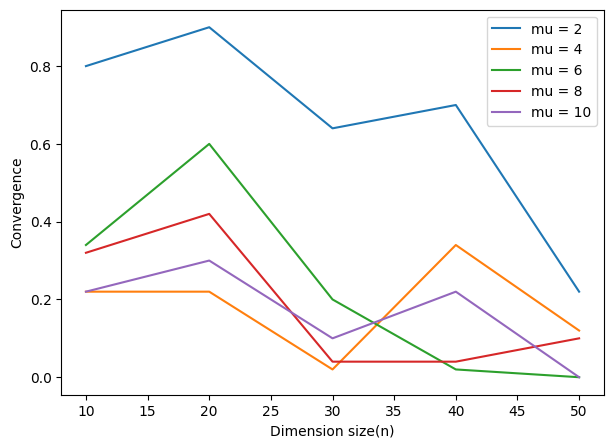

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for t_multiplier in t_multiplier_range:
    plt.plot(n_range, 1 - np.array(statistic_naive[t_multiplier]["no_sol_cnt"][:5]) / N / n_starts, label=f"mu = {t_multiplier}")
plt.xlabel("Dimension size(n)")
plt.ylabel("Convergence")
plt.legend()
plt.show()

#### Мы сравнили наивный и модифицированный метод (его резултаты ниже), можно заметить, что Ньютон из infeasible точек имеет больший процент сходимости. Мы до конца не поняли, с чем это связано, но возможно алгоритм может заходить в точки, не удовлетворяющие условию Ax=b и это дает большую свободу при спуске, что положительно сказывается в задаче минимизации с такой функцией. Поэтому в дальнейшем будем рассматривать собранную статистику только по модифицированному методу

Скриншот по сходимости для примера при mu = 2, Newton at infeasible points:

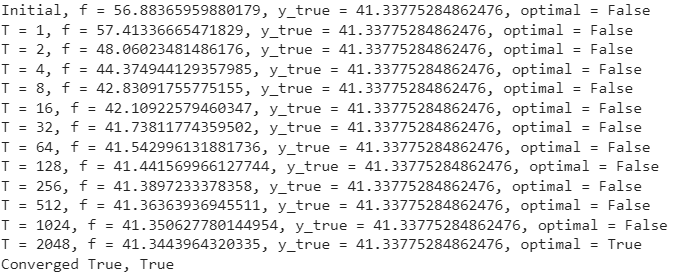

In [ ]:
statistic[2]["no_sol_cnt"]

[0, 0, 0, 0, 0]

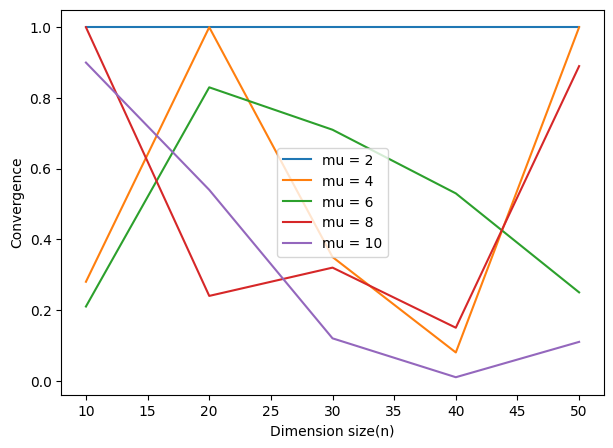

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for t_multiplier in t_multiplier_range:
    plt.plot(n_range, 1 - np.array(statistic[t_multiplier]["no_sol_cnt"]) / N / n_starts, label=f"mu = {t_multiplier}")
plt.xlabel("Dimension size(n)")
plt.ylabel("Convergence")
plt.legend()
plt.show()

#### Интересный факт, что для mu=2 сошлись абсолютно все точки. Это не баг, мы проверяли, функция действительно сходится, а точка удовлетворяет ограничениям (скриншот сходимости как раз при mu = 2, t равно степеням двойки). С увеличением mu, мы заметили, что сходимость сильно ухудшается, даже при mu=10 уже алгоритм начинает плохо работать (t меняется слишком быстро и n / t >= eps перестает выполняться, хотя спуск еще не нашел минимум). Поэтому мы взяли mu в интервале от 2 до 10 с шагом 2

## Зависимость времени работы от mu

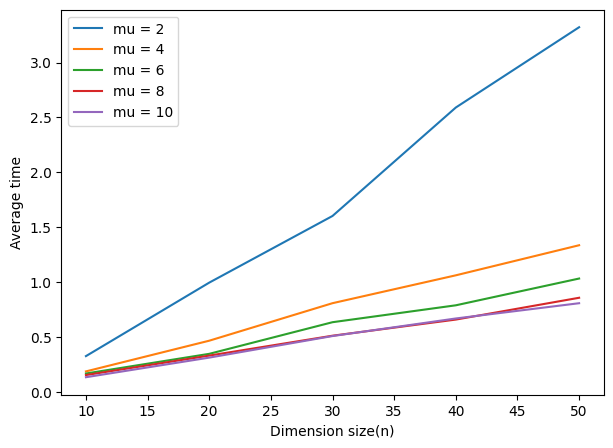

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for t_multiplier in t_multiplier_range:
    plt.plot(n_range, statistic[t_multiplier]["time"], label=f"mu = {t_multiplier}")
plt.xlabel("Dimension size(n)")
plt.ylabel("Average time")
plt.legend()
plt.show()

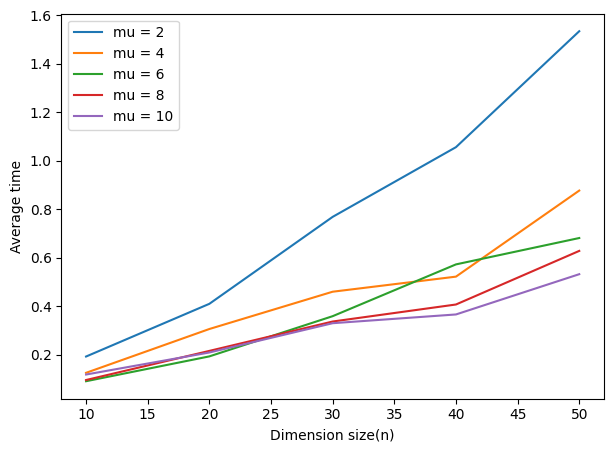

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for t_multiplier in t_multiplier_range:
    plt.plot(n_range, statistic_naive[t_multiplier]["time"][:5], label=f"mu = {t_multiplier}")
plt.xlabel("Dimension size(n)")
plt.ylabel("Average time")
plt.legend()
plt.show()

### Как и было отмечено выше, чем меньше mu, тем больше раз мы можем применить метод Ньютона в цикле, поэтому время работы обратно пропорцианально значению

## Зависимость числа итераций от mu

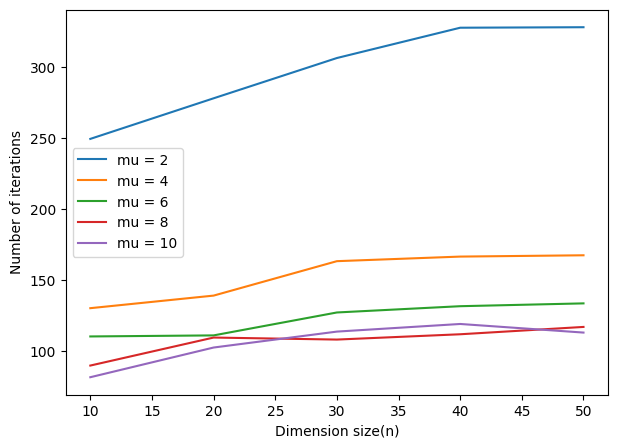

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for t_multiplier in t_multiplier_range:
    plt.plot(n_range, statistic[t_multiplier]["iters"], label=f"mu = {t_multiplier}")
plt.xlabel("Dimension size(n)")
plt.ylabel("Number of iterations")
plt.legend()
plt.show()

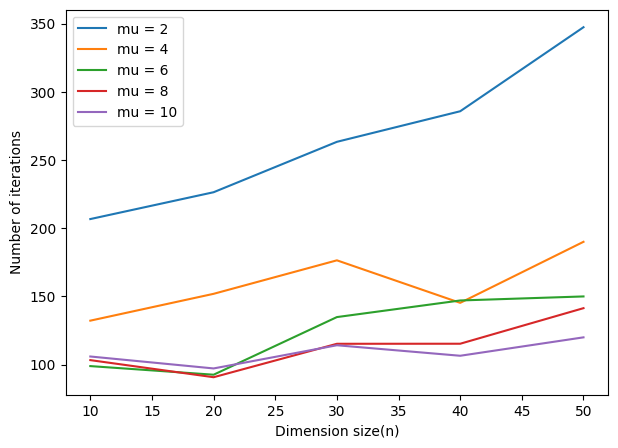

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for t_multiplier in t_multiplier_range:
    plt.plot(n_range, statistic_naive[t_multiplier]["iters"][:5], label=f"mu = {t_multiplier}")
plt.xlabel("Dimension size(n)")
plt.ylabel("Number of iterations")
plt.legend()
plt.show()

## 4.2 Средняя точность при n=10, mu - варьируется

In [ ]:
n_starts = 10  # 100
eps = 0.01
max_iters = 30
beta = 0.5
alpha = 0.0
n = 10
m = 5

prc_stat_2 = np.zeros((5, max_iters * 13))
mu_iter = 0

t_multiplier_range = [2, 4, 6, 8, 10]
pbar = tqdm.tqdm(total=N * n_starts * len(t_multiplier_range), position=0, leave=True)
for t_multiplier in t_multiplier_range:
    current_iters = 0
    for i in range(N):
        for start in range(n_starts):
            A = data[n][i]["A"]
            b = data[n][i]["b"]
            y_true = data[n][i]["y_true"]
            x = gena.normal(size=(n))
            x = make_projection(x, A, b)
            data[n][i][f"x_{start}"] = x.copy()
            mu = np.zeros(shape=(m))
            t = 1
            overall_newtons_iter = 0
            while (n / t >= eps):
                iter_cnt = 0
                while not np.isclose(calc_f(x), y_true, atol=eps):
                    delta = iter_newton(x, mu, A, b, t)
                    delta_x, delta_mu = delta[:x.shape[0]], delta[x.shape[0]:]
                    q = 1
                    while check_step_condition(x, mu, A, b, alpha, q, delta_x, delta_mu, t):
                        q = beta * q
                    x += q * delta_x
                    for xi in range(len(x)):
                        if x[xi] < 0:
                            x[xi] = 1e-2
                    mu += q * delta_mu
                    prc_stat_2[mu_iter][overall_newtons_iter] += np.abs(calc_f(x) - y_true)
                    iter_cnt += 1
                    overall_newtons_iter += 1
                    if iter_cnt == max_iters:
                        break
                current_iters += iter_cnt
                t *= t_multiplier
                if (np.isclose(calc_f(x), y_true, atol=eps)):
                    break
            if (calc_f(x) < y_true):
                pass
            pbar.update(1)
    prc_stat_2[mu_iter] = prc_stat_2[mu_iter] / N / n_starts
    mu_iter += 1

100%|██████████| 500/500 [02:18<00:00,  4.41it/s]

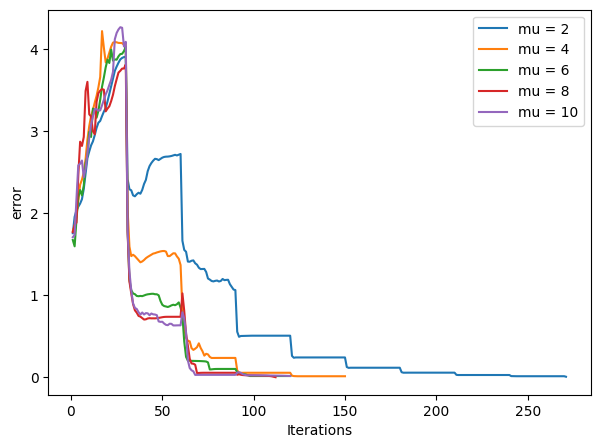

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for i in range(len(t_multiplier_range)):
    plt.plot(range(1, len(np.trim_zeros(prc_stat_2[i])) + 1), np.trim_zeros(prc_stat_2[i]), label=f"mu = {t_multiplier_range[i]}")
plt.xlabel("Iterations")
plt.ylabel("error")
plt.legend()
plt.show()

Заметим, что при больших mu алгоритм сходится за меньшее количество итераций, но при этом количество примеров, которые сошлись с заданной точностью, уменьшается. Также видно, что функция получилась со ступеньками по шагам метода логарифмически барьеров (лучше всего при mu=2)